In [1]:
# data essentials
import pandas as pd
import numpy as np
import re, os

# load the sklearn packages
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt

data_path = "/mnt/c/users/geneb/documents/USC/work/casden"

# Use Co-Star Data to Make Predictions

Data were pre-processed in the Co-Star Data Prep and Check notebook. Beside a few extra variables, the data contain a consolidation of sub-markets that somewhat aligns with Co-Star data

# Load Data

In [2]:
train = pd.read_csv("/".join([data_path, 'costart_prepped.csv']))

In [3]:
#train.loc[train.casden_submark.notnull(),:].groupby('casden_submark').Period.max()
# drop obsevations without a casden submarket
train = train.loc[train.casden_submark.notnull(),:]

# Process Data

In [4]:
# Clean up columns (need to remove / and % and the like)
train.columns = train.columns.str.replace("%|/| ",'_').str.lower()

In [5]:
# extract market
#train.loc[:,'market'] = train['geography_name'].str.extract("([\w\s]+) - CA -",expand=False).str.strip()

In [6]:
# rename a few columns for convenience
train.rename(columns = {'market_asking_rent_unit':'rent_t','absorption__':'abs_t','vacancy_rate':'vr_t','net_delivered_units_12_mo':'cnstr_t'},inplace=True)
#net_delivered_units_12_mo
#gross_delivered_units

In [7]:
train.columns[train.columns.str.contains("deliver")]

Index(['gross_delivered_buildings', 'gross_delivered_units',
       'net_delivered_units'],
      dtype='object')

In [8]:
# check which column aligns with construction intuition the most
#cols = ['period','market','net_dlvr_t','net_delivered_units_12_mo','cnstr_t','demolished_units','g_dlvr_t','gross_delivered_buildings']
#sums = train.loc[:,cols].groupby(['market','period']).sum()
#sums.loc["Los Angeles"]

In [9]:
# Create necessary lags in rent, vacancy, abs, etc(demographics later)
## Note, need to shift within submarkets hence groupby
toshift = ['rent_t','abs_t','vr_t','cnstr_t']
shftd = train.groupby('geography_name')[toshift].shift(1)
shftd2 = train.groupby('geography_name')[toshift].shift(2)
shftd3 = train.groupby('geography_name')[toshift].shift(3)
shftd4 = train.groupby('geography_name')[toshift].shift(4)

In [10]:
# rename columns with t-1 or something like it
shftd.columns = shftd.columns.str.replace("t$",'t1')
shftd2.columns = shftd2.columns.str.replace("t$",'t2')
shftd3.columns = shftd3.columns.str.replace("t$",'t3')
shftd4.columns = shftd4.columns.str.replace("t$",'t4')

In [11]:
# combine with main dataset
train = pd.concat([train,shftd,shftd2,shftd3,shftd4],axis=1)

In [12]:
# check results
sub = train.geography_name.str.contains('Culver City')
train.loc[sub,['year','period','rent_t','rent_t1']]

,year,period,rent_t,rent_t1
1360,2000,2000 Q1,1483.209595,NaN
1361,2000,2000 Q2,1512.933594,1483.209595
1362,2000,2000 Q3,1540.532837,1512.933594
1363,2000,2000 Q4,1570.116699,1540.532837
1364,2001,2001 Q1,1609.699951,1570.116699
...,...,...,...,...
1440,2020,2020 Q1,2471.695801,2478.141602
1441,2020,2020 Q2,2418.233643,2471.695801
1442,2020,2020 Q3,2378.078857,2418.233643
1443,2020,2020 Q4,2376.016113,2378.078857


In [13]:
# make a dummy for when construction is 0 or below
train.loc[:,'subzerocnstr'] = (train.cnstr_t1 <= 0).astype('int')

In [14]:
# convert periods to datetime format
train.loc[:,'time'] = train.period.str.replace(" ",'').apply(lambda x: pd.Period(x))

# Make dummy for each market and quarter

In [15]:
train.loc[:,'recession'] = train.period.isin(['2007 Q4','2008 Q1','2008 Q2','2008 Q3','2008 Q4','2009 Q1','2009 Q2']).astype('int')

In [16]:
# simplify submarket names
train.loc[:,'sub_name'] = train.geography_name.str.replace("- CA - ",'').str.replace("/| |-",'')#.shape[0] == train.geography_name.unique().shape[0]

In [17]:
train = pd.concat([train, pd.get_dummies(train.sub_name)],axis=1) 

In [18]:
# make submarket dummies and combine with main data set
train = pd.concat([train,pd.get_dummies(train.geography_name)],axis=1)

In [19]:
# make dummies and combine with main data set
#train = pd.concat([train,pd.get_dummies(train.market)],axis=1)

In [20]:
# make quarter dummies
train = pd.concat([train,pd.get_dummies(train.quarter)],axis=1)

In [21]:
# any NAs in 2021?
train.loc[train.period == '2021 Q1',['rent_t','rent_t1']].isna().any()

rent_t     False
rent_t1    False
dtype: bool

In [22]:
# make variable for covid
train.loc[:,'covid'] = (train.year == 2000).astype('int')

In [23]:
culver_tr = train.geography_name.str.contains("Culver City")
#culver_test = test.geography_name.str.contains("Culver City")

In [24]:
ventura = train.geography_name.str.contains("Ventura")


# Fit the reg models

In [25]:
# in what period do we have missing rents? (only should be the first)
train.loc[train.rent_t1.isnull(),'period'].unique()

array(['2000 Q1'], dtype=object)

In [26]:
# remove NAs
train = train.loc[train.rent_t3.notnull(),:]

## Fit Rents

In [27]:
train.loc[:,['vr_t1','vr_t2','vr_t3','rent_t2','rent_t3']]

,vr_t1,vr_t2,vr_t3,rent_t2,rent_t3
3,0.030590,0.030672,0.030945,983.852173,962.320435
4,0.030443,0.030590,0.030672,1009.071472,983.852173
5,0.030805,0.030443,0.030590,1027.035156,1009.071472
6,0.033041,0.030805,0.030443,1052.648682,1027.035156
7,0.047065,0.033041,0.030805,1076.581177,1052.648682
...,...,...,...,...,...
6625,0.100821,0.061603,0.041804,2018.846191,2011.538574
6626,0.090287,0.100821,0.061603,2004.321533,2018.846191
6627,0.078770,0.090287,0.100821,2003.302734,2004.321533
6628,0.085847,0.078770,0.090287,2055.125244,2003.302734


# Sand Box

In [28]:
groups = train.groupby(['casden_submark'])

In [29]:
train.casden_submark.unique()

array(['Rancho Cucamonga-San Bernardino', 'Palm Springs-Indio',
       'West Riverside County', 'Long Beach-South Bay',
       'Coastal Communities - Beverly Hills', 'Burbank-Glendale',
       'Downtown', 'Koreatown-Mid City', 'Inglewood',
       'San Fernando Valley', 'Pasadena', 'San Gabriel',
       'Palmdale-Lancaster-Santa Clarita', 'South/Southeast Los Angeles',
       'Anaheim-West Orange Central', 'Irvine-South-East-OC',
       'Huntington-Seal-Coastal-OC', 'La Habra-North OC',
       'City of San Diego (Coastal)', 'Chula Vista-National City',
       'City of San Diego (Inland)', 'North County',
       'Oxnard-Port Hueneme-Ventura', 'Simi Valley'], dtype=object)

In [30]:
groups = train.groupby(['casden_submark'])
group = groups.get_group('Inglewood')

In [31]:
group_tr = group.loc[(group.year<2019),:]
group_test = group.loc[group.year>=2019,:]

In [32]:
group_tr.shape[0]

73

In [33]:
group_test.shape[0]

9

In [34]:
# set var to predict
#y = 'rent_t'
#y = "vr_t"
y= 'cnstr_t'

#X = ['abs_t1','abs_t2','abs_t3','vr_t1','vr_t2','vr_t3','rent_t1','rent_t2','rent_t3','Q2','Q3','Q4']
#X = ['vr_t1','vr_t2','vr_t3','cnstr_t1','cnstr_t2','cnstr_t3','cnstr_t4','abs_t1','Q2','Q3','Q4','covid'] #,,'cnstr_t3'
X = ['rent_t1','rent_t2','vr_t1','vr_t2','cnstr_t1','cnstr_t2','Q2','Q3','Q4','covid'] #,'abs_t1','cnstr_t4','vr_t3'
#,'rent_t3','cnstr_t4','abs_t1','abs_t2','cnstr_t3'

# get submarket 
subMarks = group_test.sub_name.sort_values().unique()[1:]
# add sub-market dummies
X.extend(subMarks) 

# set the model
model = LinearRegression()

# fit the model
model.fit(group_test.loc[:,X],group_test.loc[:,y])

LinearRegression()

In [35]:
# construct prediction vs real dictionary
comp = pd.DataFrame({"preds":model.predict(group_test.loc[:,X]),"real":group_test[y],
                     'tru_weights':group_test['market_weight_qrt'],
                     'submarket':group_test['geography_name'],
                     'period':group_test['period']})

lastweight = group_tr.groupby('geography_name').market_weight_qrt.apply(lambda x: x.iloc[-1])#group_tr.groupby('geography_name').market_weight_qrt.mean()
comp = comp.merge(lastweight, left_on ='submarket', right_index=True)

comp.set_index(['period','submarket'],inplace=True)

In [36]:
comp

,,preds,real,tru_weights,market_weight_qrt
period,submarket,,,,
2019 Q1,Los Angeles - CA - Greater Inglewood,89.0,89.0,0.051774,0.051955
2019 Q2,Los Angeles - CA - Greater Inglewood,99.0,99.0,0.051617,0.051955
2019 Q3,Los Angeles - CA - Greater Inglewood,99.0,99.0,0.051598,0.051955
2019 Q4,Los Angeles - CA - Greater Inglewood,74.0,74.0,0.051267,0.051955
2020 Q1,Los Angeles - CA - Greater Inglewood,182.0,182.0,0.051272,0.051955
2020 Q2,Los Angeles - CA - Greater Inglewood,253.0,253.0,0.051907,0.051955
2020 Q3,Los Angeles - CA - Greater Inglewood,318.0,318.0,0.051502,0.051955
2020 Q4,Los Angeles - CA - Greater Inglewood,282.0,282.0,0.051054,0.051955
2021 Q1,Los Angeles - CA - Greater Inglewood,506.0,506.0,0.050764,0.051955


In [37]:
errDict = {}
# check errors:
errDict['submarket'] = comp[['preds','real']].diff(axis=1).iloc[:,1].abs().mean()#/comp.real).mean()

n = comp.shape[0]
comp_aggr = np.multiply(comp[['preds','real']],comp.market_weight_qrt.values.reshape(n,1)).groupby('period').sum()
errDict['lst_wgt_market'] = comp_aggr[['preds','real']].diff(axis=1).iloc[:,1].abs().mean()#/comp_aggr.real).mean()

tru = np.multiply(comp['real'], comp.tru_weights).groupby('period').sum()
preds = np.multiply(comp.preds,comp.market_weight_qrt).groupby('period').sum()
errDict['tru_vs_last_wgt_market'] = (tru - preds).abs().mean()#/tru.mean()

pd.Series(errDict)

submarket                 5.987507e-12
lst_wgt_market            3.110598e-13
tru_vs_last_wgt_market    1.414822e-01
dtype: float64

## Fit Rents

In [38]:
# initiate container
rentDict = {}

# set var to predict
y = 'rent_t'

for label, group in train.groupby('market'): 
    print(label)
    # set base model features
    if label == 'Inland Empire':
        #print("here")
        X = ['vr_t1','vr_t2','rent_t1','rent_t2','Q2','Q3','Q4']
        #,'abs_t3', ,'rent_t3','vr_t3','abs_t1','abs_t2',
    else:
        X = ['abs_t1','vr_t1','vr_t2','rent_t1','rent_t2','Q2','Q3','Q4','covid']
        
    # remove NAs caused by lags
    maxlag = np.max([int(i) for i in re.findall("(\d)","|".join(X))])
    group = group.loc[(group['rent_t'+str(maxlag)]).notnull(),:]
    
    # get submarket 
    subMarks = group.sub_name.sort_values().unique()[1:]
    # add sub-market dummies
    X.extend(subMarks) 

    # set the model
    model = LinearRegression()

    # fit the model
    if (label == 'Ventura') | (label == 'Inland Empire'):
        cond = (group.year<=2019)
        model.fit(group.loc[cond,X],group.loc[cond,y])
    else:
        model.fit(group.loc[:,X],group.loc[:,y])
        
    # save fitted model, features, and parameter estimates
    rentDict[label] = {'features':X, 'model':model,"param_est":pd.Series(model.coef_.flatten(),index = X)}

Inland Empire
Los Angeles
Orange County
San Diego
Ventura


In [39]:
# check on the fit
X = rentDict['Los Angeles']['features']
cond = (train.year>2010) & (train.market == 'Los Angeles')
preds = rentDict['Los Angeles']['model'].predict(train.loc[cond,X]).flatten()
real = train.loc[cond,'rent_t']
print("Avg percent between fit and real: %.2f %%" %((preds - real)/real*100).abs().mean())

Avg percent between fit and real: 0.47 %


### Fit Vacancies

In [40]:
# initiate container
vrDict = {}

# set var to predict
y = 'vr_t'

for label, group in train.groupby('market'):  
    print(label)
    
    # set base model features
    if label == 'Ventura':
        X = ['abs_t1','vr_t1','vr_t2','rent_t1','rent_t2','Q2','Q3','Q4','covid']   
        
    if label == 'Inland Empire':
        X = ['vr_t1','vr_t2','vr_t3','cnstr_t1','cnstr_t2','cnstr_t3','cnstr_t4','abs_t1','Q2','Q3','Q4','covid','recession'] #,,'cnstr_t3'
        #
        
    else:
        X = ['vr_t1','vr_t2','vr_t3','cnstr_t1','cnstr_t2','cnstr_t3','abs_t1','Q2','Q3','Q4','covid'] #
    
    # remove NAs caused by lags
    maxlag = np.max([int(i) for i in re.findall("(\d)","|".join(X))])
    group = group.loc[(group['rent_t'+str(maxlag)]).notnull(),:]
    
    # get submarket 
    subMarks = group.sub_name.sort_values().unique()[1:]
    # add sub-market dummies
    X.extend(subMarks) 
    
    # initiate the model
    model = LinearRegression()

    # fit the model
    cond = group[X].notnull().all(axis=1) # exclude NAs
    model.fit(group.loc[cond,X],group.loc[cond,y])
    
    # save fitted model, features, and parameter estimates
    vrDict[label] = {'features':X, 'model':model,"param_est":pd.Series(model.coef_.flatten(),index = X)}

Inland Empire
Los Angeles
Orange County
San Diego
Ventura


In [41]:
# check on the fit
X = vrDict['Los Angeles']['features']
cond = (train.year>2010) & (train.market == 'Los Angeles')
preds = vrDict['Los Angeles']['model'].predict(train.loc[cond,X]).flatten()
real = train.loc[cond,y]
print("Avg percent between fit and real: %.2f %%" %((preds - real)/real*100).abs().mean())

Avg percent between fit and real: 5.31 %


### Fit Construction

In [42]:
# initiate container
cnstrDict = {}

# set var to predict
y = 'cnstr_t'

for label, group in train.groupby('market'):  
    print(label)
    # set base model features
    if label == 'San Diego':
        X = ['rent_t1','rent_t2','rent_t3','vr_t1','vr_t2','cnstr_t1','cnstr_t2','cnstr_t3','abs_t1','Q2','Q3','Q4','covid'] 
        
    if label == 'Inland Empire':
        X = ['rent_t1','rent_t2','vr_t1','vr_t2','cnstr_t1','cnstr_t2','cnstr_t3','Q2','Q3','Q4','covid','recession']
    
    #if label == 'Los Angeles':
    #    X = ['rent_t1','rent_t2','rent_t3','vr_t1','vr_t2','vr_t3','cnstr_t1','cnstr_t2','Q2','Q3','Q4','abs_t1'] #,'abs_t1','cnstr_t3','cnstr_t4'
    else:
        X = ['rent_t1','rent_t2','rent_t3','vr_t1','vr_t2','vr_t3','cnstr_t1','cnstr_t2','cnstr_t3','cnstr_t4','Q2','Q3','Q4','covid','abs_t1'] #,
    
    # remove NAs caused by lags
    maxlag = np.max([int(i) for i in re.findall("(\d)","|".join(X))])
    group = group.loc[(group['rent_t'+str(maxlag)]).notnull(),:]
    
    # get submarket 
    subMarks = group.sub_name.sort_values().unique()[1:]
    # add sub-market dummies
    X.extend(subMarks) 
    
    # initiate the model
    model = LinearRegression()

    # fit the model
    cond = group[X].notnull().all(axis=1) # exclude NAs
    model.fit(group.loc[cond,X],group.loc[cond,y])
    
    # save fitted model, features, and parameter estimates
    cnstrDict[label] = {'features':X, 'model':model,"param_est":pd.Series(model.coef_.flatten(),index = X)}

Inland Empire
Los Angeles
Orange County
San Diego
Ventura


In [43]:
# check on the fit
X = cnstrDict['Los Angeles']['features']
cond = (train.year>2010) & (train.market == 'Los Angeles')
preds = cnstrDict['Los Angeles']['model'].predict(train.loc[cond,X]).flatten()
real = train.loc[cond,y]
print("Median diff between fit and real: %.2f units" %((preds - real)).abs().mean())

Median diff between fit and real: 75.92 units


## Fit Absorption

In [44]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

In [45]:
groups = train.groupby("market")
group = groups.get_group("Los Angeles")

<AxesSubplot:xlabel='time'>

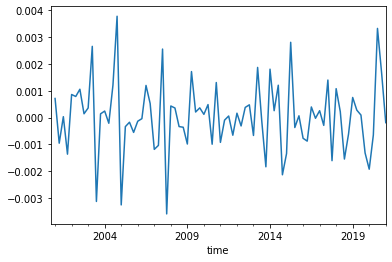

In [46]:
group.groupby('time').abs_t.mean().diff().plot()

(0.0, 10.0)

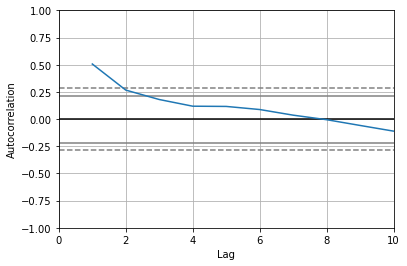

In [47]:
autocorrelation_plot(group.groupby('time').abs_t.mean().dropna())
plt.xlim((0,10))

In [48]:
series = group.groupby('time').abs_t.mean().iloc[:-10]
testseries = group.groupby('time').abs_t.mean().iloc[-10:]
model = ARIMA(series, order=(1,0,0)).fit()
pd.concat([model.predict(start = 75,end=83), testseries],axis=1).diff(axis=1).abs().mean()

predicted_mean         NaN
abs_t             0.001534
dtype: float64

In [49]:
(group.groupby('time').abs_t.mean().iloc[-10:] - group.groupby('time').abs_t.mean().iloc[:-10].mean()).abs().mean()

0.0011910079629629628

**Honestly**, using absorption means as the predictor works better than an ARIMA

In [50]:
# initiate container
absDict = {}

# set var to predict
y = 'abs_t'

for label, group in train.groupby('market'):  
    print(label)
    # set base model features
    
    # save fitted model, features, and parameter estimates
    absDict[label] = {'abs_mean':group.abs_t.mean().mean()}

Inland Empire
Los Angeles
Orange County
San Diego
Ventura


# Make Predictions

Goal is to go 1 quarter at a time forward in each of the variables and itirate until we make all of the predictions

In [51]:
# make periods for which to predict
predPeriods = [" ".join([str(y),q]) for y in np.arange(2021,2024,1) for q in ['Q1','Q2','Q3','Q4']]

# skip 2021 Q1
predPeriods = predPeriods[1:]

print("Making predictions for:", predPeriods)

Making predictions for: ['2021 Q2', '2021 Q3', '2021 Q4', '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4', '2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4']


## Make initial data frame

This is a bit convoluted. Co-Star does not report 2021 Q1 figures for all geographies with the majority of geographies only being reported up to 2020 Q4. As a result, to get the initial data frame, I find the last observed value for each geography and use that amalgamation for the starting data

In [52]:
lags = train.columns[train.columns.str.contains("_t\d?$")]
lags

Index(['abs_t', 'rent_t', 'cnstr_t', 'vr_t', 'rent_t1', 'abs_t1', 'vr_t1',
       'cnstr_t1', 'rent_t2', 'abs_t2', 'vr_t2', 'cnstr_t2', 'rent_t3',
       'abs_t3', 'vr_t3', 'cnstr_t3', 'rent_t4', 'abs_t4', 'vr_t4',
       'cnstr_t4'],
      dtype='object')

In [53]:
# find the latest period with observations
lastseen = train.groupby('geography_name')[['period']].transform('max')

cols2include = ['market_weight_qrt', 'market_weight_qrt_cas','period','year','market','sub_name','casden_submark','geography_name','subzerocnstr']
cols2include.extend(lags)
init_idx = train.loc[(train.period == lastseen['period']) & (train.year>=2020),cols2include]
init_idx.shape[0]

68

In [54]:
init_idx.columns

Index(['market_weight_qrt', 'market_weight_qrt_cas', 'period', 'year',
       'market', 'sub_name', 'casden_submark', 'geography_name',
       'subzerocnstr', 'abs_t', 'rent_t', 'cnstr_t', 'vr_t', 'rent_t1',
       'abs_t1', 'vr_t1', 'cnstr_t1', 'rent_t2', 'abs_t2', 'vr_t2', 'cnstr_t2',
       'rent_t3', 'abs_t3', 'vr_t3', 'cnstr_t3', 'rent_t4', 'abs_t4', 'vr_t4',
       'cnstr_t4'],
      dtype='object')

In [55]:
# use the average of absorption rate
# try ARIMA on absorption
# parameter estimates on updated works

### Make forecast dataframe

Essentially, a frame with empty values but with correct quarter and market dummies. 

This table will be progressively filled with predictions

In [56]:
# make a dataframe with index of every co-star and year-quarter to predict
multiIndex = pd.MultiIndex.from_product([predPeriods,init_idx.loc[init_idx.year>=2020,'geography_name'].unique()])
preds = pd.DataFrame({'rent_t':0,'cnstr_t':0,'vr_t':0,'covid':0,'subzerocnstr':0},index = multiIndex)
preds.index.names = ['period','geography_name']
preds.reset_index(inplace=True)
preds.loc[:,'sub_name'] = preds.geography_name.str.replace("- CA - ",'').str.replace("/| |-",'')#.shape[0] == train.geography_name.unique().shape[0]
preds.loc[:,'recession'] = 0
# make and attach dummies
preds.loc[:,'quarter'] = preds.period.str[-2:]
preds.loc[:,'market'] = preds['geography_name'].str.extract("([\w\s]+) - CA -",expand=False).str.strip()
qdums =  pd.get_dummies(preds.quarter)
mdums = pd.get_dummies(preds.sub_name)
preds = pd.concat([preds,qdums,mdums],axis=1)

In [57]:
# add lag columns with NA values
for lagged in train.columns[train.columns.str.contains("t\d")]:
    preds.loc[:,lagged] = np.nan

In [58]:
# sort the initial and prediction df by geography name
preds.sort_values(['period','geography_name'],inplace=True)
init_idx.sort_values('geography_name',inplace=True)

In [59]:
# assign the avg absorption rate of each sub-market as abs_t1
avg_abs = train.loc[train.year<2020].groupby('geography_name').abs_t.mean()
avg_abs.name = 'abs_mean'
preds = preds.merge(avg_abs, left_on = 'geography_name', right_index=True)
preds.abs_t1.fillna(preds.abs_mean,inplace=True)
preds.abs_t2.fillna(preds.abs_mean,inplace=True)
preds.abs_t3.fillna(preds.abs_mean,inplace=True)

In [60]:
# assign latest observed value as Q2 lag values
for col in ['rent_t','vr_t','cnstr_t','abs_t']:
    for i in range(0,4):
        if i > 0:
            preds.loc[preds.period == '2021 Q2',col+str(i+1)] = init_idx.loc[:,col + str(i)].values
        else:
            preds.loc[preds.period == '2021 Q2',col+"1"] = init_idx.loc[:,col].values

## Make Predictions

In [61]:
#if any(['abs_t' in s for s in xd[key]]):
#                maxabslag = np.max([int(i) for i in re.findall("abs_t(\d)","|".join(xd[key]))])
#                condnew = (preds.period == predPeriods[i+1]) & (preds.market == label)
#                print(maxabslag)
#                for k in range(maxabslag+1):
#                    if k == 0:
#                        preds.loc[condnew,key+'_t'] = preds.loc[cond,key+"_t"].values
#                    else:
#                        preds.loc[condnew,key+'_t'+str(k)] = preds.loc[cond,key+"_t"+str(k)].values

In [62]:
# make successive predictions for each market
#for label, group in preds.groupby('geography_name'):
for label, group in preds.groupby('market'):

    print(label)
    # extract model fit and the like
    xd = {}
    xd['rent'] = rentDict[label]['features']
    xd['vr'] = vrDict[label]['features']
    xd['cnstr'] = cnstrDict[label]['features']
    
    lrd = {}
    lrd['rent'] = rentDict[label]['model']
    lrd['vr'] = vrDict[label]['model']
    lrd['cnstr'] = cnstrDict[label]['model']
    
    for i, predPeriod in enumerate(predPeriods):
        #print(predPeriod)
        for key in ['rent','vr','cnstr']:
            maxlag = np.max([int(i) for i in re.findall("(\d)","|".join(xd[key]))])
            #print(maxlag)
            cond = (preds.period == predPeriod) & (preds.market == label)
            preds.loc[cond,key+"_t"] = lrd[key].predict(preds.loc[cond,xd[key]]).flatten()
            if i<(len(predPeriods)-1):
                # assign current t value to next period's lag
                condnew = (preds.period == predPeriods[i+1]) & (preds.market == label)
                if key+"_t" in preds.columns:
                    for j in range(maxlag):
                        if (j == 0):
                            preds.loc[condnew,key+'_t1'] = preds.loc[cond,key+"_t"].values
                        if (j < 4) & (j > 0):
                            preds.loc[condnew,key+'_t'+str(j+1)] = preds.loc[cond,key+"_t"+str(j)].values

Inland Empire
Los Angeles
Orange County
San Diego
Ventura


# Attach weights and market info to predictions

In [63]:
cols2include = ['casden_submark','geography_name','market_weight_qrt', 'market_weight_qrt_cas']
preds = preds.merge(init_idx.loc[:,cols2include], on='geography_name')

# Attach predictions to observed data

In [64]:
# clean up the preds by removing dummies
preds = preds.loc[:,~preds.columns.str.contains("LosAngeles|Inland|Orange|SanDiego|Ventura|sub_name|Q\d")]

In [65]:
df = pd.concat([train.loc[:,preds.columns.difference(['abs_mean'])].set_index(['period','geography_name']),preds.set_index(['period','geography_name'])])

# Aggregate from Co-Star sub-markets

## Aggregate to Market


Weighted average of observed and predicted values

In [66]:
df.casden_submark.unique()

array(['Rancho Cucamonga-San Bernardino', 'Palm Springs-Indio',
       'West Riverside County', 'Long Beach-South Bay',
       'Coastal Communities - Beverly Hills', 'Burbank-Glendale',
       'Downtown', 'Koreatown-Mid City', 'Inglewood',
       'San Fernando Valley', 'Pasadena', 'San Gabriel',
       'Palmdale-Lancaster-Santa Clarita', 'South/Southeast Los Angeles',
       'Anaheim-West Orange Central', 'Irvine-South-East-OC',
       'Huntington-Seal-Coastal-OC', 'La Habra-North OC',
       'City of San Diego (Coastal)', 'Chula Vista-National City',
       'City of San Diego (Inland)', 'North County',
       'Oxnard-Port Hueneme-Ventura', 'Simi Valley'], dtype=object)

In [67]:
# multiply each observation by its weight
n = df.shape[0]
wqrt = np.multiply(df[['rent_t','vr_t']],df['market_weight_qrt'].values.reshape(n,1))#.groupby(level=0).mean()
wqrt.columns = ['wgt_' + s for s in wqrt.columns]
df = pd.concat([df,wqrt],axis=1)

In [68]:
# sum across the weights
toplot = df.groupby(['period','market'])[wqrt.columns.union(['cnstr_t'])].sum()

In [69]:
toplot

cnstr_t   wgt_rent_t  wgt_vr_t
period  market                                           
2000 Q4 Inland Empire     0.000000   796.088088  0.041974
        Los Angeles       0.000000  1023.564026  0.025344
        Orange County     0.000000  1212.749414  0.029185
        San Diego         0.000000   949.703080  0.024058
        Ventura           0.000000  1210.344708  0.033036
...                            ...          ...       ...
2023 Q4 Inland Empire  1813.167450  1913.200997  0.027918
        Los Angeles    4551.214885  1645.037205  0.040986
        Orange County  4085.174511  2301.358104  0.046517
        San Diego      3149.065262  1846.886394  0.042453
        Ventura         610.291406  2316.019189  0.040761

[465 rows x 3 columns]

## Aggregate to Casden sub-market

# Visualize Predictions

In [70]:
# rename columns
toplot.rename(columns = {'wgt_rent_t':'rent','wgt_vr_t':'vacancy rate','cnstr_t':'net delivered'},inplace=True)

In [71]:
# turn quarters to something that's machine readable for indexing
toplot.reset_index(inplace=True)
toplot.loc[:,'time'] = toplot.reset_index().period.str.replace(" ",'').apply(lambda x: pd.Period(x))

In [72]:
sub = toplot.time.astype('str').str.contains('Q1')
toplot.loc[:,'labels'] = ''#toplot.time.astype('str').str[-2:]
toplot.loc[sub,'labels'] = toplot.loc[sub,'time'].dt.year
#toplot.loc[~sub,'labels'] = 

In [73]:
toplot.set_index(['market','time'],inplace=True)

In [74]:
toplot.drop('labels',axis=1).sort_index().to_csv("/".join([data_path, 'market_level_predictions.xlsx']))

<ipython-input-75-ffa53987a200>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[valid | forecast])


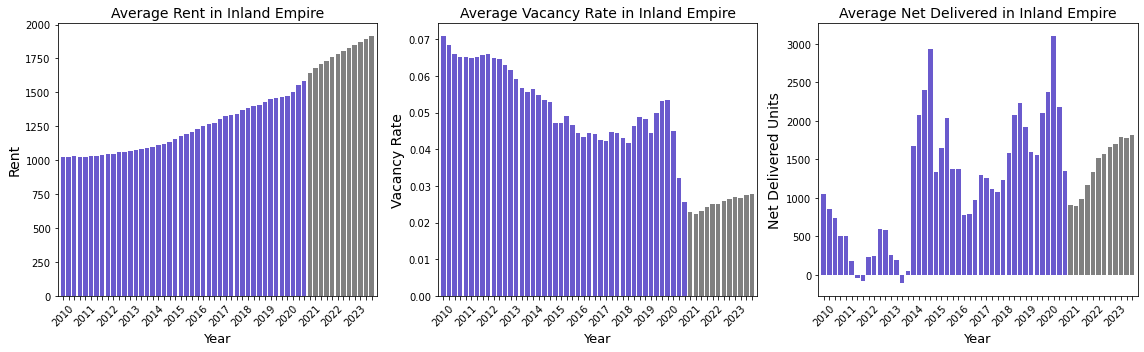

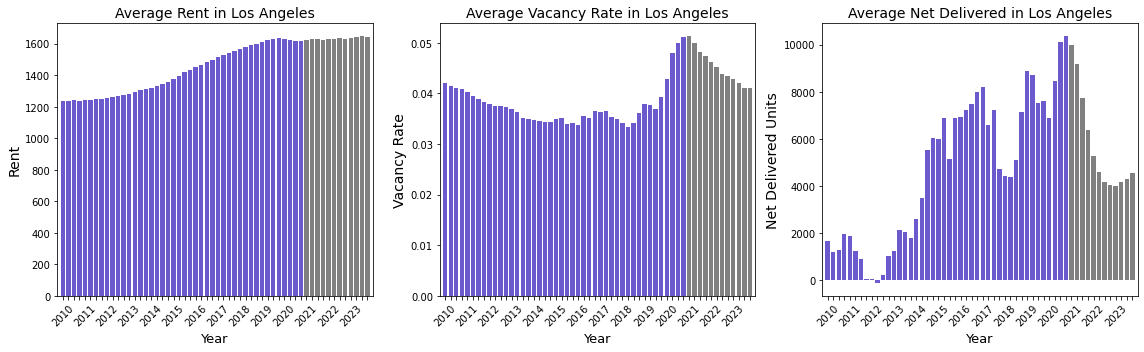

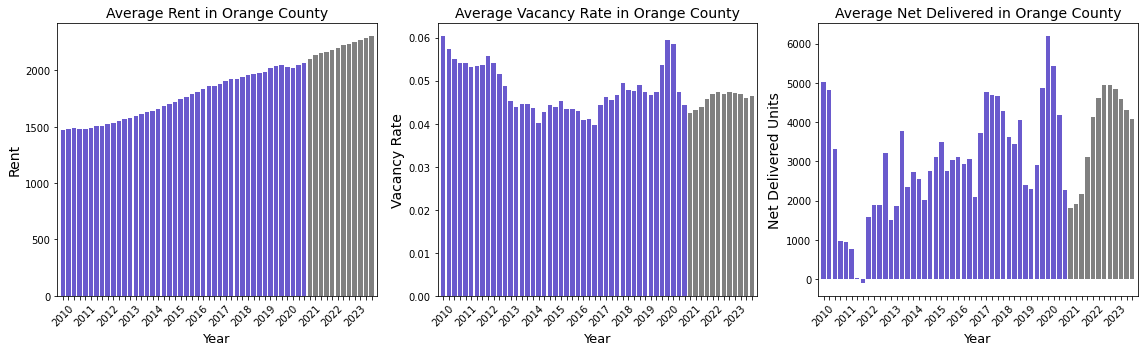

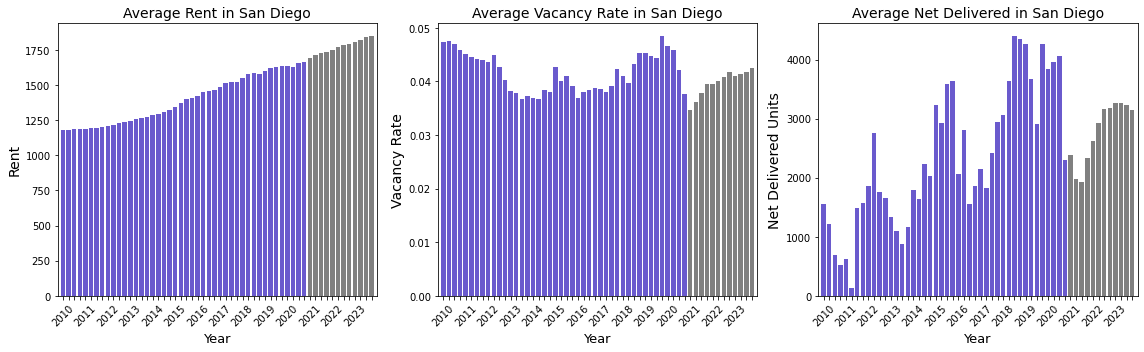

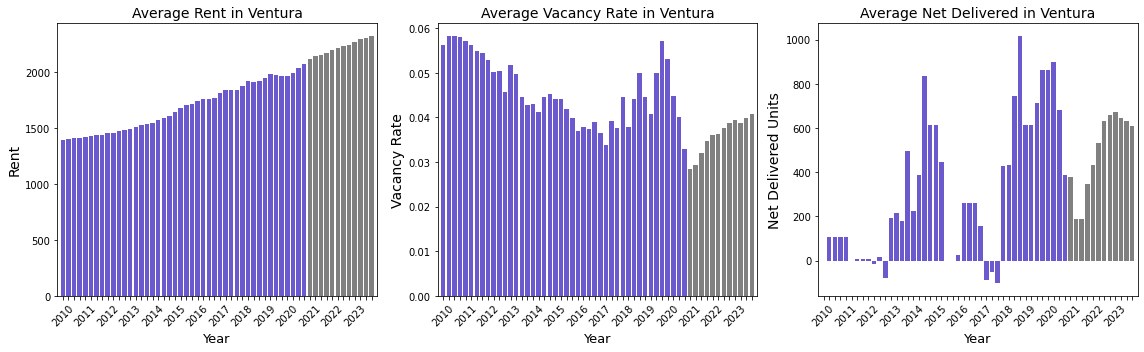

In [75]:
for label, group in toplot.groupby(level=0):
    fig, axes = plt.subplots(1,3)
    for key,ax in zip(['rent','vacancy rate','net delivered'],axes.flatten()):
        labels = group.loc[label,'labels']
        tmp = group.loc[label,key]
        
        valid,forecast = (tmp.index>(pd.Period('2009Q4'))) & (tmp.index<=(pd.Period('2021Q1'))),tmp.index>(pd.Period('2020Q4'))
        
        ax.bar(x = tmp.loc[valid].index.astype("str").str.replace("Q"," Q"), height = tmp[valid],color='slateblue',width=.8)
        ax.bar(x = tmp.loc[forecast].index.astype("str").str.replace("Q"," Q"), height = tmp[forecast],color='grey')
        #tmp[valid].plot(color='purple',ax=ax, linewidth=3)
        #tmp[forecast].plot(color='grey',ax=ax, linewidth=3)
        #ax.plot(x = tmp.loc[valid].index.astype("str").str.replace("Q"," Q"), y = tmp[valid],color='purple')
        #tmp.iloc[:-11].plot(ax = ax, color = 'purple')
        #tmp.iloc[-11:].plot(ax=ax,color='grey')
        #group.plot(kind = 'bar',width=.93,color='orange')
        ax.set_title("Average %s in %s" %(key.title(),label), fontsize = 14)
        ax.set_xticklabels(labels[valid | forecast])
        ax.set_xlabel("Year", fontsize = 13)
        if key == 'net delivered':
            ax.set_ylabel("Net Delivered Units", fontsize = 14)
        else:
            ax.set_ylabel("%s" %key.title(), fontsize = 14)
        ax.margins(x=.01)    
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        fig.set_figheight(5)
        fig.set_figwidth(16)
    plt.savefig("/".join([data_path, "predictions4%s.png" %(label)]), dpi=300)

# Export Parameter Estimates

In [76]:
paramDict = {}
for label, group in train.groupby('market'):
    print(label)
    coefs = pd.concat([rentDict[label]['param_est'],vrDict[label]['param_est'],cnstrDict[label]['param_est']],axis=1,keys = ['rent','vr','cnstr'])
    coefs = coefs.loc[~coefs.index.str.contains("LosAngeles|Ventura|San|Inland|Orange"),:]
    #coefs.loc[~coefs.index.str.contains("Ventura"),:]
    paramDict[label] = coefs

Inland Empire
Los Angeles
Orange County
San Diego
Ventura


In [77]:
paramest = pd.concat(paramDict,axis=1)
paramest.to_csv("/".join([data_path, 'param_est.csv']))

# Sub-market Predictions

In [78]:
df.columns

Index(['abs_t1', 'abs_t2', 'abs_t3', 'abs_t4', 'casden_submark', 'cnstr_t',
       'cnstr_t1', 'cnstr_t2', 'cnstr_t3', 'cnstr_t4', 'covid', 'market',
       'market_weight_qrt', 'market_weight_qrt_cas', 'quarter', 'recession',
       'rent_t', 'rent_t1', 'rent_t2', 'rent_t3', 'rent_t4', 'subzerocnstr',
       'vr_t', 'vr_t1', 'vr_t2', 'vr_t3', 'vr_t4', 'abs_mean', 'wgt_rent_t',
       'wgt_vr_t'],
      dtype='object')

In [79]:
# multiply each observation by its weight
n = df.shape[0]
wqrt = np.multiply(df[['rent_t','vr_t']],df['market_weight_qrt_cas'].values.reshape(n,1))#.groupby(level=0).mean()
wqrt.columns = ['caswgt_' + s for s in wqrt.columns]
df = pd.concat([df,wqrt],axis=1)

In [80]:
# sum across the weights
toplot = df.groupby(['period','casden_submark'])[wqrt.columns.union(['cnstr_t'])].sum()

In [81]:
# rename
# rename columns
toplot.rename(columns = {'caswgt_rent_t':'rent','caswgt_vr_t':'vacancy rate','cnstr_t':'net delivered'},inplace=True)

In [82]:
# turn quarters to something that's machine readable for indexing
toplot.reset_index(inplace=True)
toplot.loc[:,'time'] = toplot.reset_index().period.str.replace(" ",'').apply(lambda x: pd.Period(x))
#

In [83]:
sub = toplot.time.astype('str').str.contains('Q1')
toplot.loc[:,'labels'] = ''#toplot.time.astype('str').str[-2:]
toplot.loc[sub,'labels'] = toplot.loc[sub,'time'].dt.year

In [84]:
toplot.set_index(['casden_submark','time'],inplace=True)

<ipython-input-85-31ac3ca59e02>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[valid | forecast])
<ipython-input-85-31ac3ca59e02>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,3)


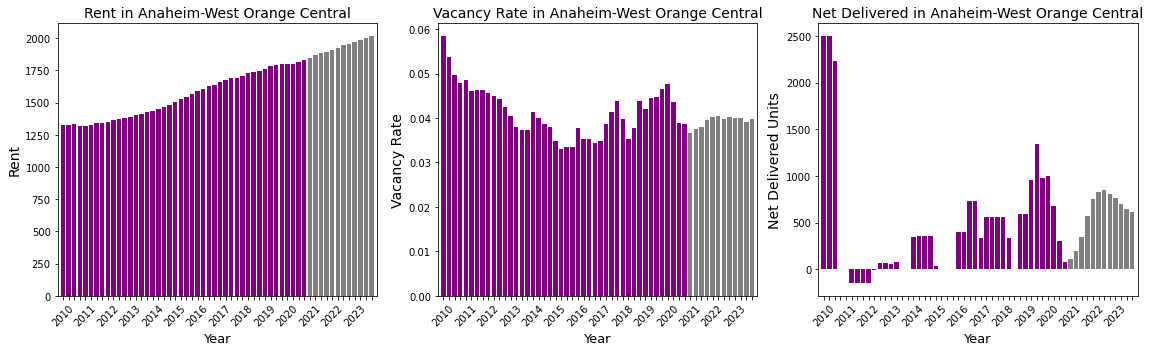

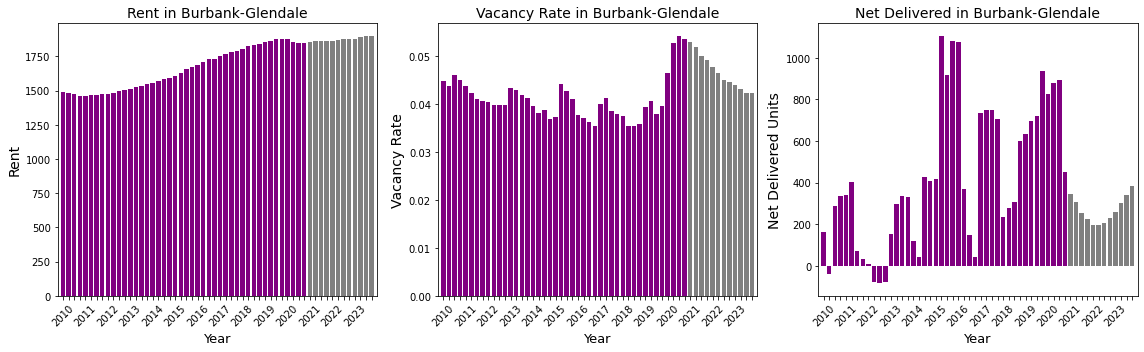

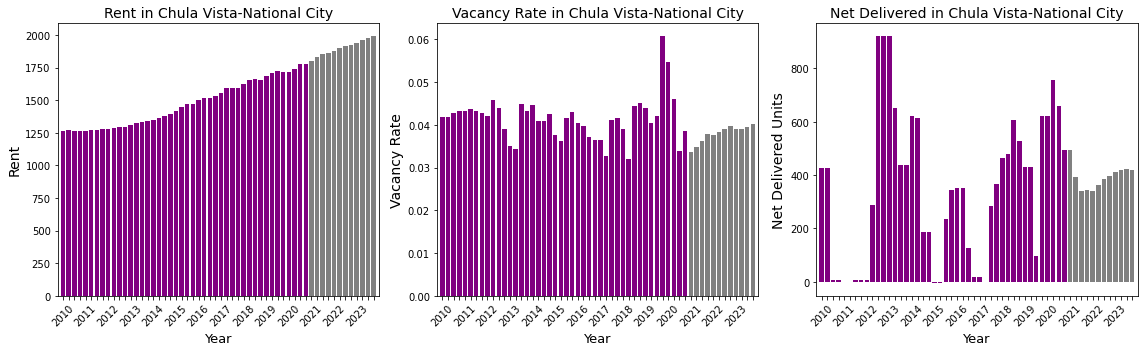

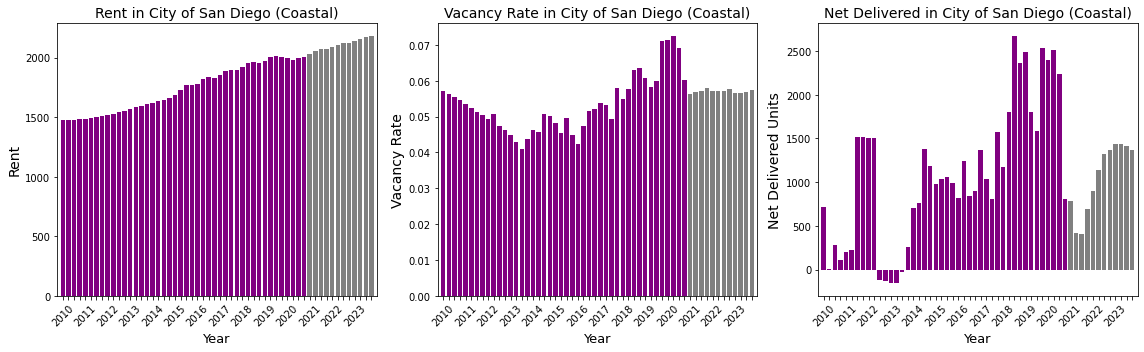

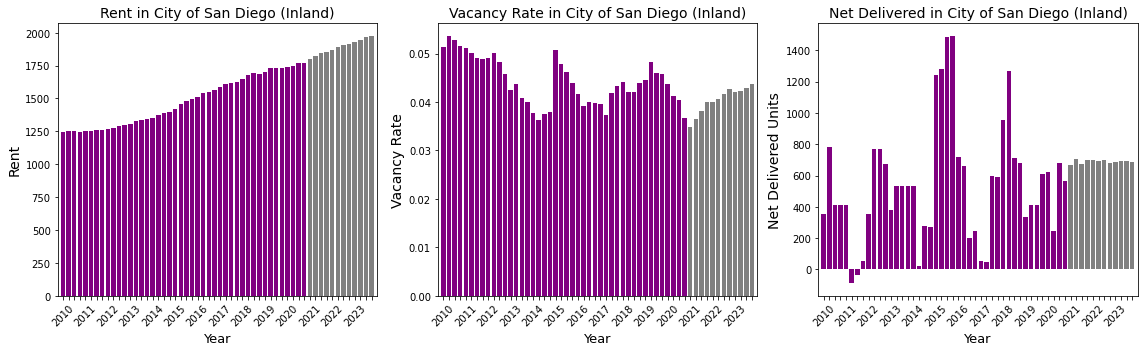

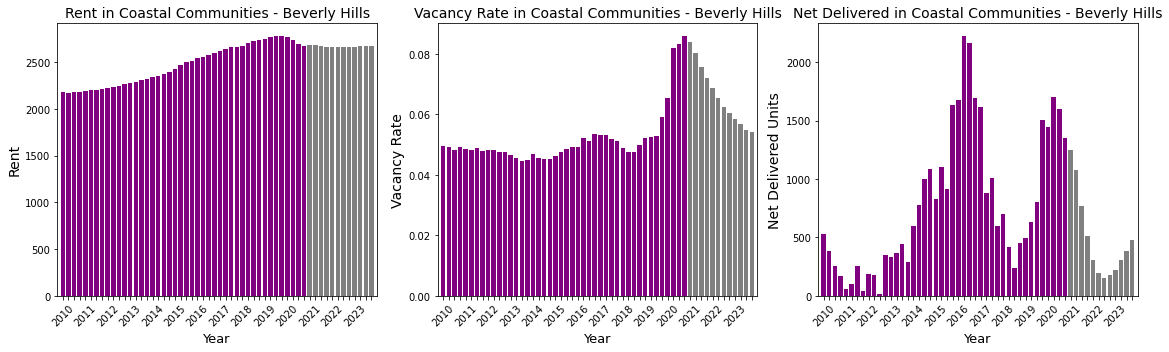

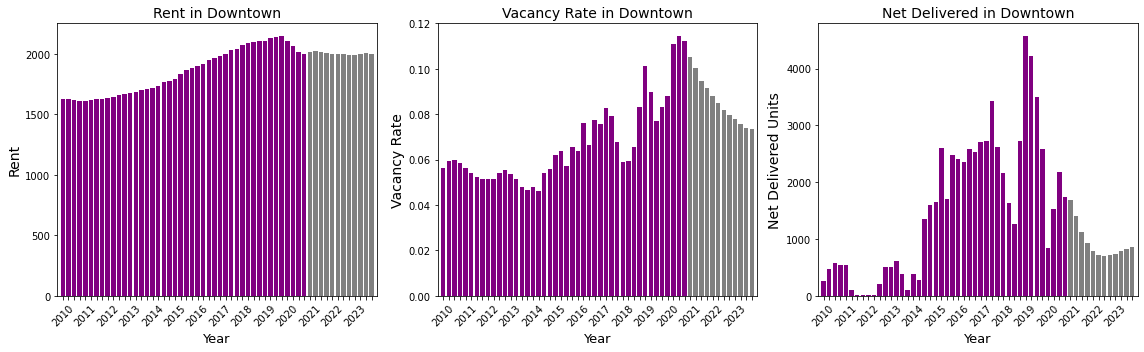

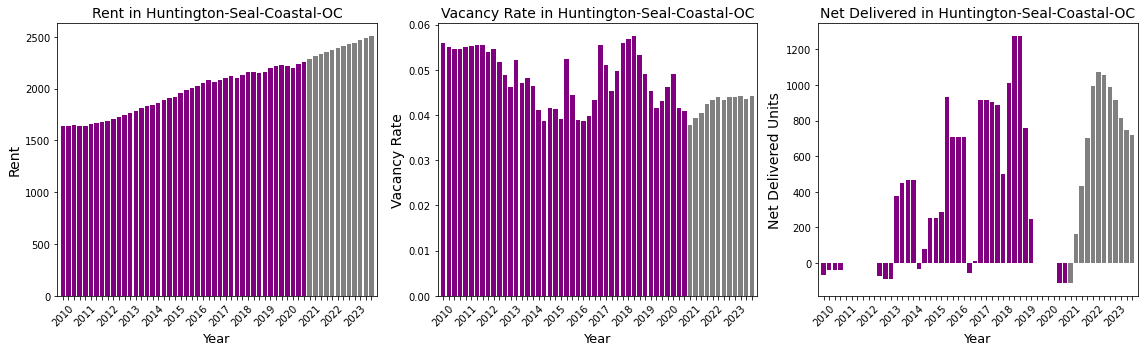

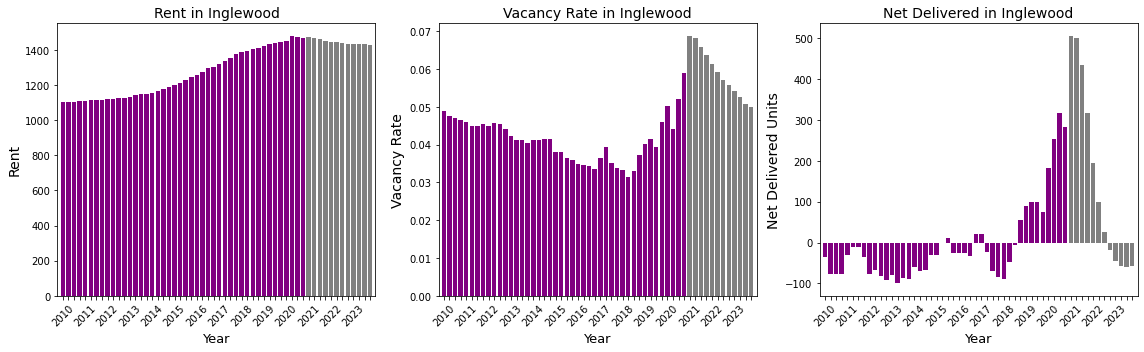

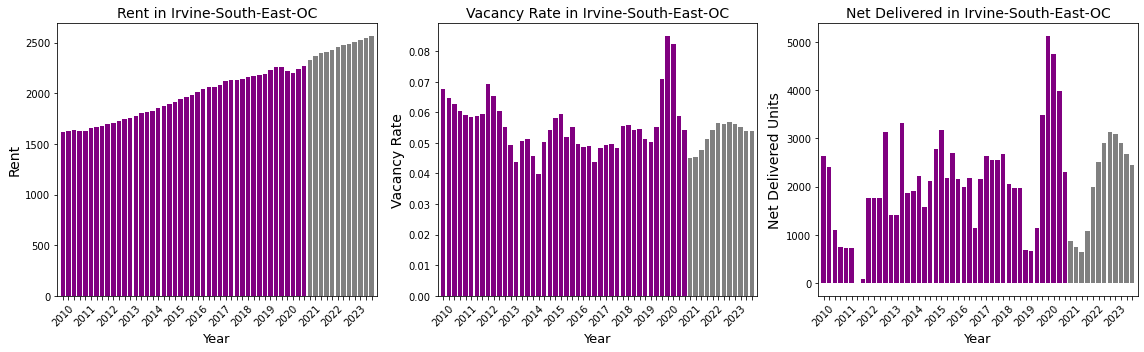

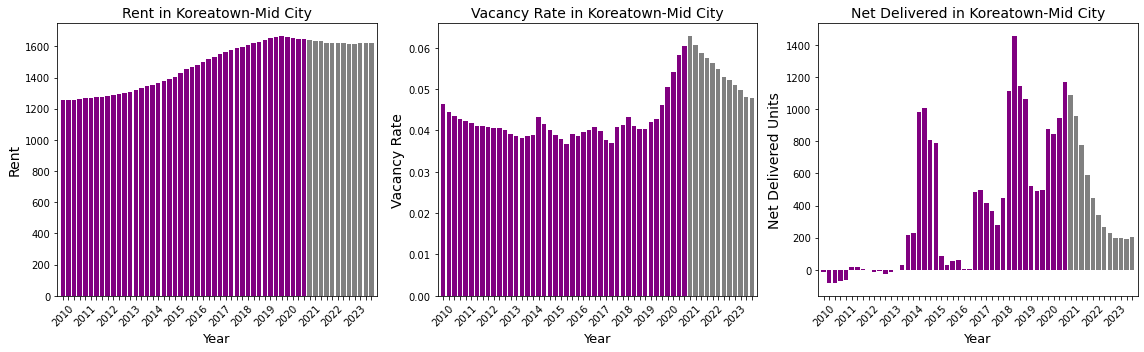

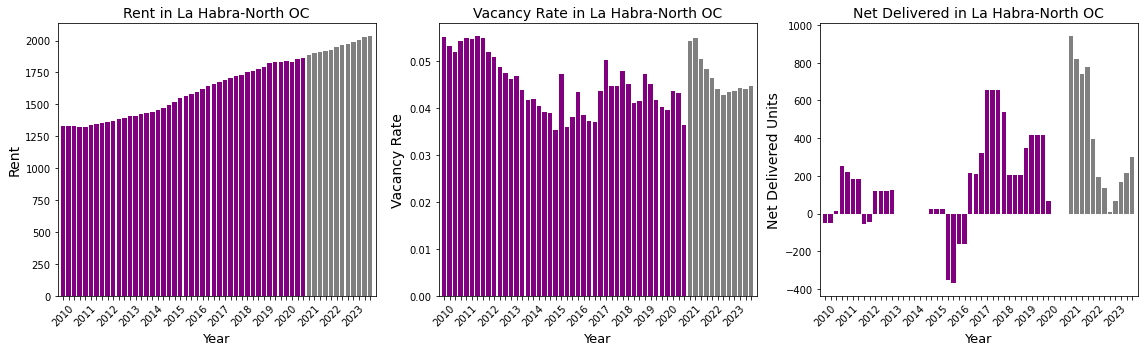

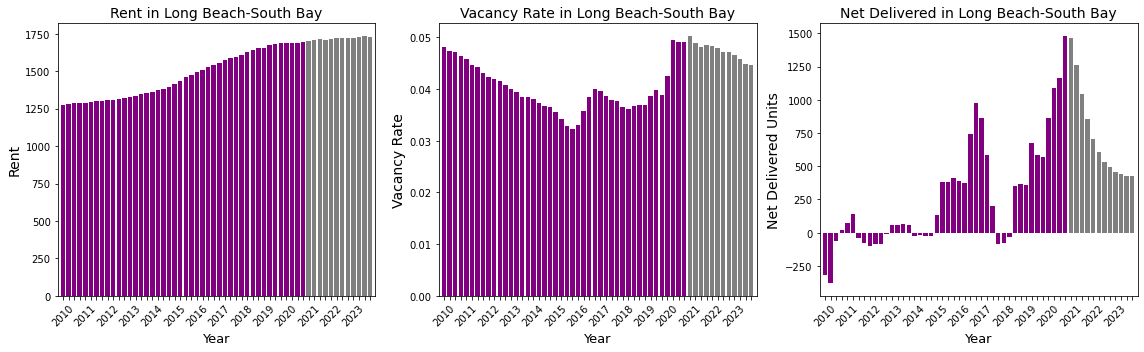

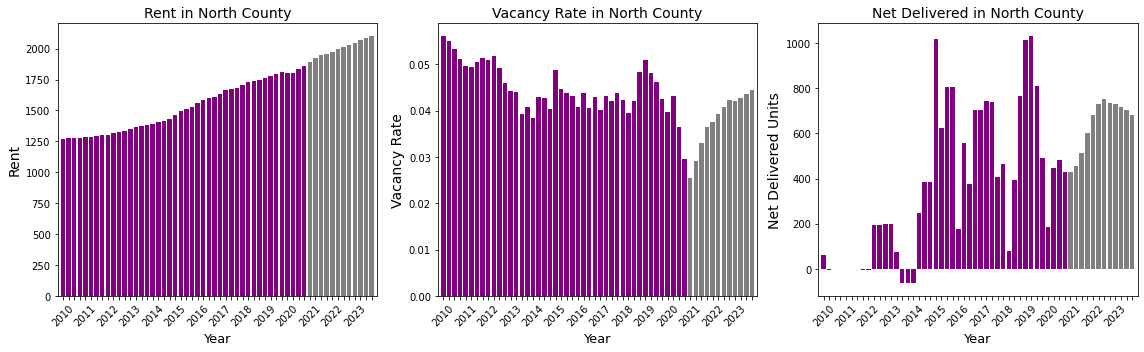

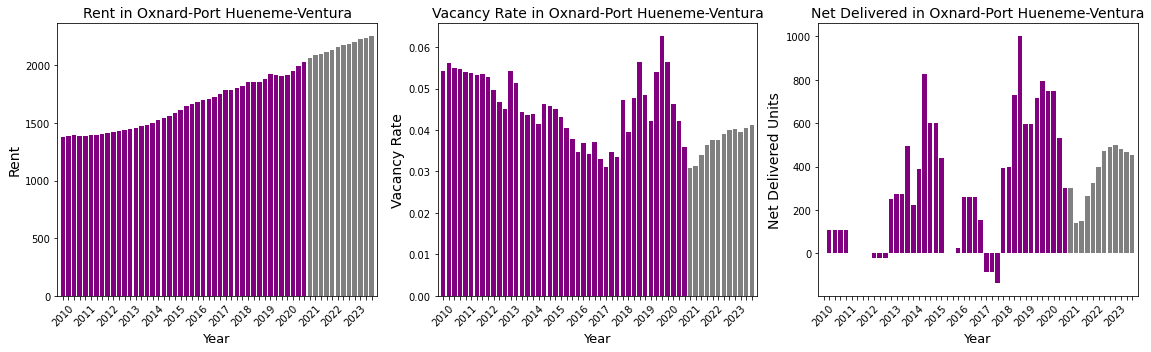

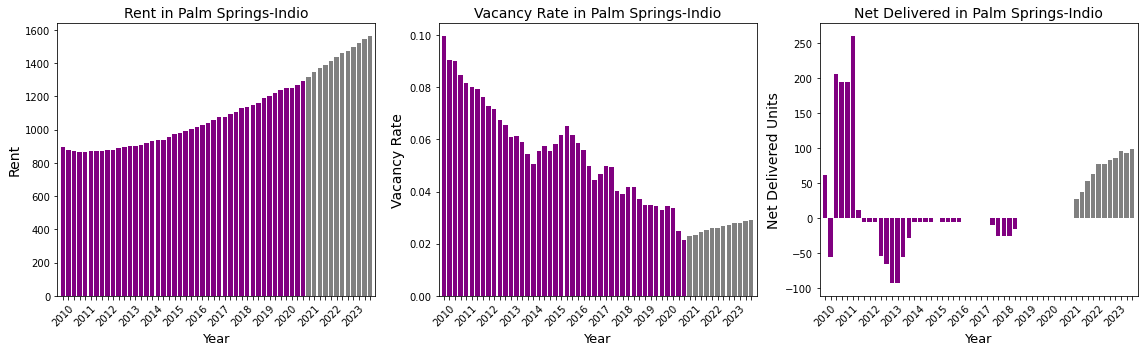

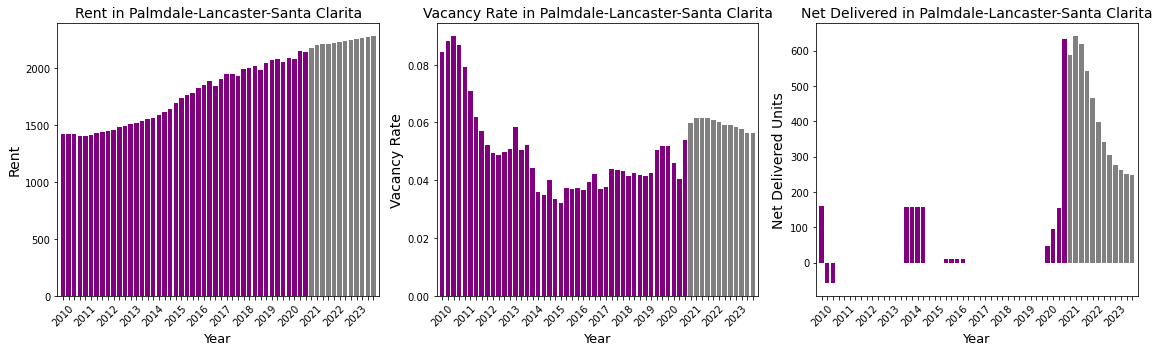

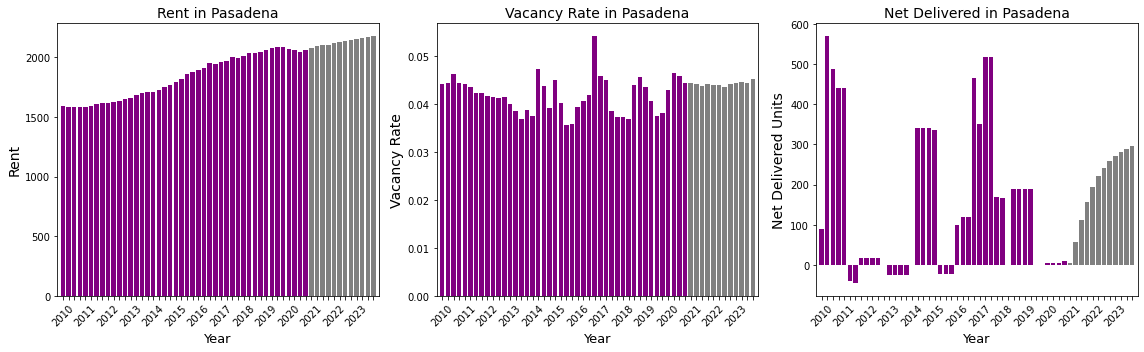

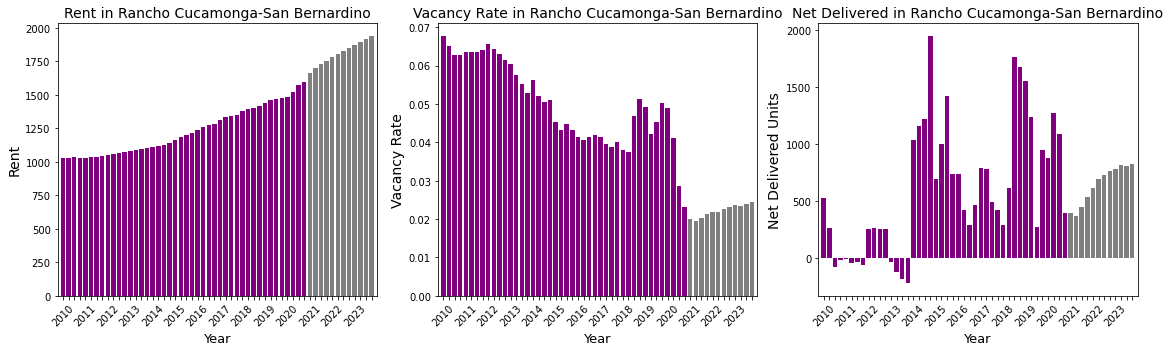

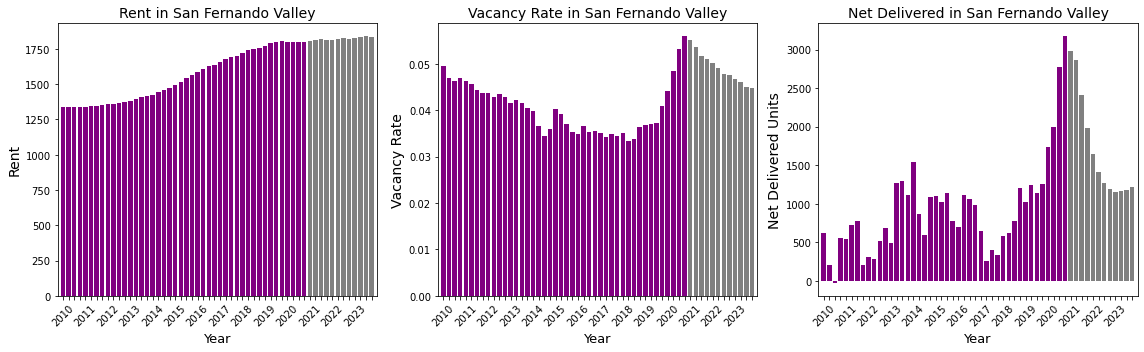

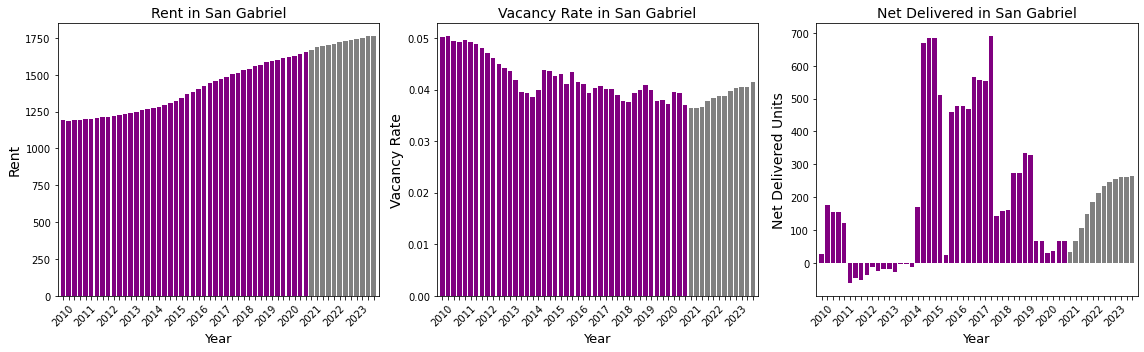

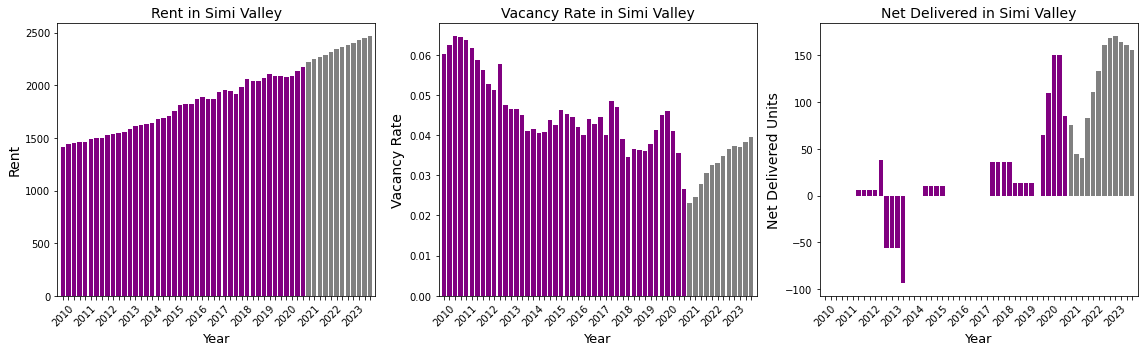

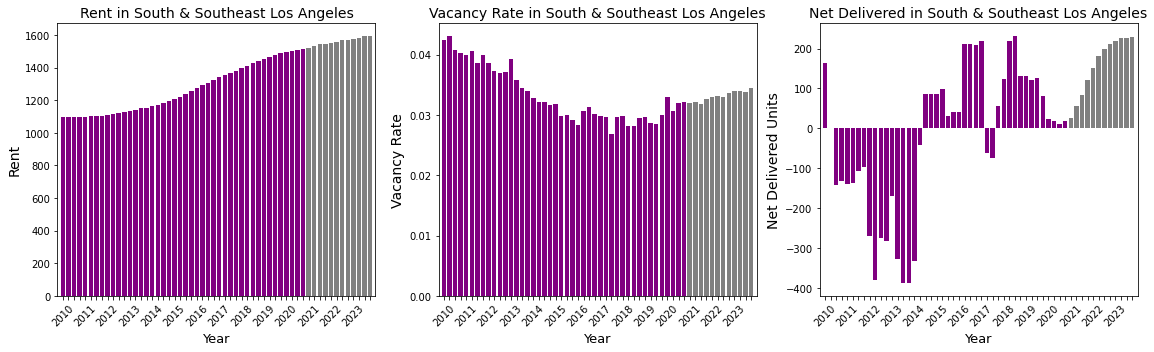

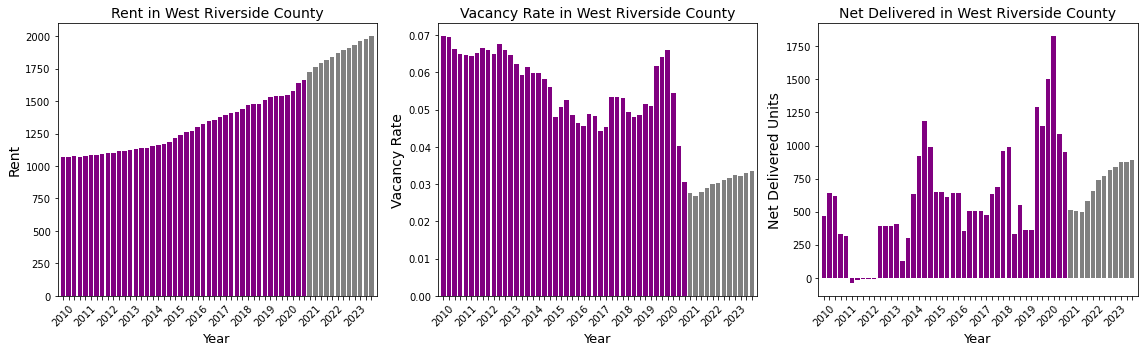

In [85]:
for label, group in toplot.groupby(level=0):
    fig, axes = plt.subplots(1,3)
    for key,ax in zip(['rent','vacancy rate','net delivered'],axes.flatten()):
        labels = group.loc[label,'labels']
        tmp = group.loc[label,key]
        
        valid,forecast = (tmp.index>(pd.Period('2009Q4'))) & (tmp.index<=(pd.Period('2021Q1'))),tmp.index>(pd.Period('2020Q4'))
        
        ax.bar(x = tmp.loc[valid].index.astype("str").str.replace("Q"," Q"), height = tmp[valid],color='purple',width=.8)
        ax.bar(x = tmp.loc[forecast].index.astype("str").str.replace("Q"," Q"), height = tmp[forecast],color='grey')

        
        ax.set_title("%s in %s" %(key.title(),label.replace("/"," & ")), fontsize = 14)
        ax.set_xticklabels(labels[valid | forecast])
        ax.set_xlabel("Year", fontsize = 13)
        if key == 'net delivered':
            ax.set_ylabel("Net Delivered Units", fontsize = 14)
        else:
            ax.set_ylabel("%s" %key.title(), fontsize = 14)
        ax.margins(x=.01)    
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        fig.set_figheight(5)
        fig.set_figwidth(16)
    plt.savefig("/".join([data_path, "predictions4%s.png" %(label.replace("/",""))]), dpi=300)

In [90]:
df.market.unique()

array(['Inland Empire', 'Los Angeles', 'Orange County', 'San Diego',
       'Ventura'], dtype=object)

In [91]:
df.loc[df.market.str.contains("Orange"),'casden_submark'].unique()

array(['Anaheim-West Orange Central', 'Irvine-South-East-OC',
       'Huntington-Seal-Coastal-OC', 'La Habra-North OC'], dtype=object)

In [96]:
toplot.loc[['Anaheim-West Orange Central', 'Irvine-South-East-OC',
       'Huntington-Seal-Coastal-OC', 'La Habra-North OC']].drop('labels',axis=1).to_excel("/".join([data_path, 'OC_submarket_predictions.xlsx']))

# Growth Prediction Sorting 

Make a table of submarkets ranked by growth in rent between 2020 Q4 - 2021 Q1 and 2021 Q2- 2021 Q3

In [87]:
# make a table of markets and submarkets
marktosubmark = df[['casden_submark','market']].drop_duplicates().set_index('casden_submark')

In [88]:
toplot.reset_index(level=1,inplace=True)

In [89]:
# merge the markets to the submarkets
toplot = toplot.merge(marktosubmark, right_index = True, left_index=True)

In [90]:
toplot.reset_index(inplace=True)

In [92]:
toplot.loc[:,'quarter'] = toplot.time.dt.quarter

In [95]:
# isolate periods of interest
toplot.loc[:,'before'] = toplot.period.isin(['2020 Q2','2020 Q3','2020 Q4','2021 Q1'])
toplot.loc[:,'after'] = toplot.period.isin(['2021 Q2','2021 Q3','2021 Q4','2022 Q1'])

### Change in annual average

In [98]:
tblDict = {}

In [99]:
# compute average change
b4r = toplot.loc[toplot.before,:].groupby(['market','casden_submark']).rent.mean()
aftr = toplot.loc[toplot.after,:].groupby(['market','casden_submark']).rent.mean() 

tblDict['avg'] = ((aftr - b4r)/b4r).round(4).groupby(level=0).apply(lambda x: x.sort_values())

### Avg quarter-to-quarter

In [122]:
diffs = toplot.loc[toplot.before | toplot.after,:].groupby(['market','casden_submark','quarter']).rent.diff().dropna()
first =  toplot.loc[toplot.before | toplot.after,:].groupby(['market','casden_submark','quarter']).rent.first()

In [123]:
diffs.index = first.index

In [128]:
tblDict['qrt2qrt'] = (diffs/first).groupby(level=[0,1]).mean().groupby(level=0).apply(lambda x: x.sort_values(ascending=False))

### Avg quarterly change

In [158]:
toplot.loc[:,'rent_diffs'] = toplot.loc[:,:].groupby(['market','casden_submark']).rent.transform('diff')

In [159]:
toplot.loc[:,'shftd_rent_diffs'] = toplot.rent_diffs.shift(-1)

In [160]:
toplot.loc[:,'rentChange'] = (toplot.shftd_rent_diffs/toplot.rent)

In [166]:
avgChange = toplot.loc[(toplot.before | toplot.after) & (toplot.time>'2021Q1'),:].groupby(['market','casden_submark']).rentChange.mean()

In [170]:
tblDict['avgChange'] = avgChange.groupby(['market']).apply(lambda x: x.sort_values(ascending=False))

## Save the output

In [172]:
from pandas import ExcelWriter

In [173]:
#outtable.to_excel("/".join([data_path, 'growth_table.xlsx']))

In [174]:
with ExcelWriter("/".join([data_path, 'growth_table_ver2.xlsx'])) as writer:
        for key in tblDict.keys():
            tblDict[key].to_excel(writer,key)
        writer.save()